# Tarea 3 - Inteligencia Artificial IIC2613

## Detección de Noticias Falsas



Diego Iruretagoyena - 14619164 - diiru@uc.cl

En esta tarea utilizaremos técnicas vistas en clase para identificar notificias falsas. 
Para esto, realizaremos los siguientes pasos:

- Preprocesamiento de los datos.
- Tranformación a feature space númerico utilizando Bag of Words, Word2Vec y Bert.
- Clasificación usando SVM y Random Forest
- Analizar los resultados obtenidos.

## AC00: Lectura y pre-procesamiento de datos

Pasos:
- Leer CSVs
- Eliminar nulos
- Taggear según Noticia Verdadera o Falsa
- Filtrar Stopwords y ruido como caracteres no alfabeticos
- Pasar a minuscula


In [87]:
import operator
import re
import textblob
from textblob import Word
import nltk

import warnings
import pandas as pd
import numpy as np
import multiprocessing

from sklearn.svm import SVC
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import Image
from nltk.corpus import stopwords

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.metrics import accuracy_score, confusion_matrix

from nltk.probability import FreqDist
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Leemos los CSVs y limpiamos nulos

true_df = pd.read_csv('True.csv')
false_df = pd.read_csv('Fake.csv')

true_df.dropna()
false_df.dropna()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [3]:
# Revisamos contenido True.CSV

true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
# Revisamos contenido False.CSV

false_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
# Taggeamos segun Verdadero / Falso y juntamos todo en un dataset.

for i, db in enumerate([true_df, false_df]):
    db['label'] = [i for j in range(db.shape[0])]
    
df = pd.concat([true_df, false_df])
df = df.sample(frac=1).reset_index(drop=True)
df.head()


,title,text,subject,date,label
0,Iran denies U.S. accusation of destabilizing t...,BEIRUT (Reuters) - Iran s foreign ministry den...,worldnews,"December 6, 2017",0
1,"Despite flaws, paperless voting machines remai...",WASHINGTON (Reuters) - One in four registered ...,politicsNews,"September 20, 2016",0
2,German coalition candidates want 40 percent cu...,BERLIN (Reuters) - German parties in explorato...,worldnews,"October 26, 2017",0
3,SLICK SCAM: John Kerry Warns Global Warming Wi...,"Sure, we need to save people from something th...",Government News,"Oct 9, 2015",1
4,Guatemala top court sides with U.N. graft unit...,GUATEMALA CITY (Reuters) - Guatemala s top cou...,worldnews,"August 29, 2017",0


In [6]:
print(len(df))

44898


In [53]:
labels_ = df['label']

Ahora limpiamos stopwords y caracteres especiales (ruido)

In [7]:
# nltk.download('wordnet')

In [8]:
stop = stopwords.words('english')
text_tokenize, text_cleanned = [], []
for i, text in enumerate(df['text']):
    new_text = re.sub('[^a-zA-Z]+',' ', text)
    new_text = new_text.lower()
    new_text = [word for word in new_text.split(sep=' ') if not word in stop]
    new_text = [Word(word).lemmatize() for word in new_text]
    text_tokenize.append(new_text)
    text_cleanned.append(" ".join(new_text))
    
df['text_tokenize'] = text_tokenize
df['text_cleanned'] = text_cleanned
df.head(5)

,title,text,subject,date,label,text_tokenize,text_cleanned
0,Iran denies U.S. accusation of destabilizing t...,BEIRUT (Reuters) - Iran s foreign ministry den...,worldnews,"December 6, 2017",0,"[beirut, reuters, iran, foreign, ministry, den...",beirut reuters iran foreign ministry denied we...
1,"Despite flaws, paperless voting machines remai...",WASHINGTON (Reuters) - One in four registered ...,politicsNews,"September 20, 2016",0,"[washington, reuters, one, four, registered, v...",washington reuters one four registered voter u...
2,German coalition candidates want 40 percent cu...,BERLIN (Reuters) - German parties in explorato...,worldnews,"October 26, 2017",0,"[berlin, reuters, german, party, exploratory, ...",berlin reuters german party exploratory talk f...
3,SLICK SCAM: John Kerry Warns Global Warming Wi...,"Sure, we need to save people from something th...",Government News,"Oct 9, 2015",1,"[sure, need, save, people, something, naturall...",sure need save people something naturally occu...
4,Guatemala top court sides with U.N. graft unit...,GUATEMALA CITY (Reuters) - Guatemala s top cou...,worldnews,"August 29, 2017",0,"[guatemala, city, reuters, guatemala, top, cou...",guatemala city reuters guatemala top court tue...


In [9]:
# Guardamos csv para ahorrar tiempo
df.to_csv("preprocessed_db.csv")

# Train / Validation / Test set

Con el objetivo de crear embeddings sin traspaso de informacion, separaremos el dataset en 3, creando sets de datos para entrenar, validar y testear nuestros clasificadores.

Lo que haremos será entrenar los embeddings con el de Train, para luego generar los embeddings del test. Reservaremos el 20% de los datos para testear nuestros modelos.

In [10]:
preprocessed_db = pd.read_csv('preprocessed_db.csv')

train_df, test_df = train_test_split(preprocessed_db, test_size=0.2)

train_df.to_csv("preprocessed_train_db.csv")
test_df.to_csv("preprocessed_test_db.csv")

## AC01: Histograma

Haga un análisis de las palabras más utilizadas en el dataset. En particular, construya un histograma de frecuencia, en el cual el eje X contenga las palabras ordenadas según valores decrecientes de frecuencia. Comente acerca de la forma de este histograma.


In [11]:
words = {}
for row in df['text_tokenize']:
    for w in row:
        if not w in words:
            words[w] = 1
        else:
            words[w] += 1
words = sorted(words.items(), key= operator.itemgetter(1), reverse=True)

keys, values = [], []
all_art = []
for k, v in words:
    if v >= 8000:
        keys.append(k)
        values.append(v)

for row in df['text_tokenize']:
    article = []
    for wrd in row:
        if wrd in keys:
            article.append(wrd)
    all_art.append(' '.join(article))


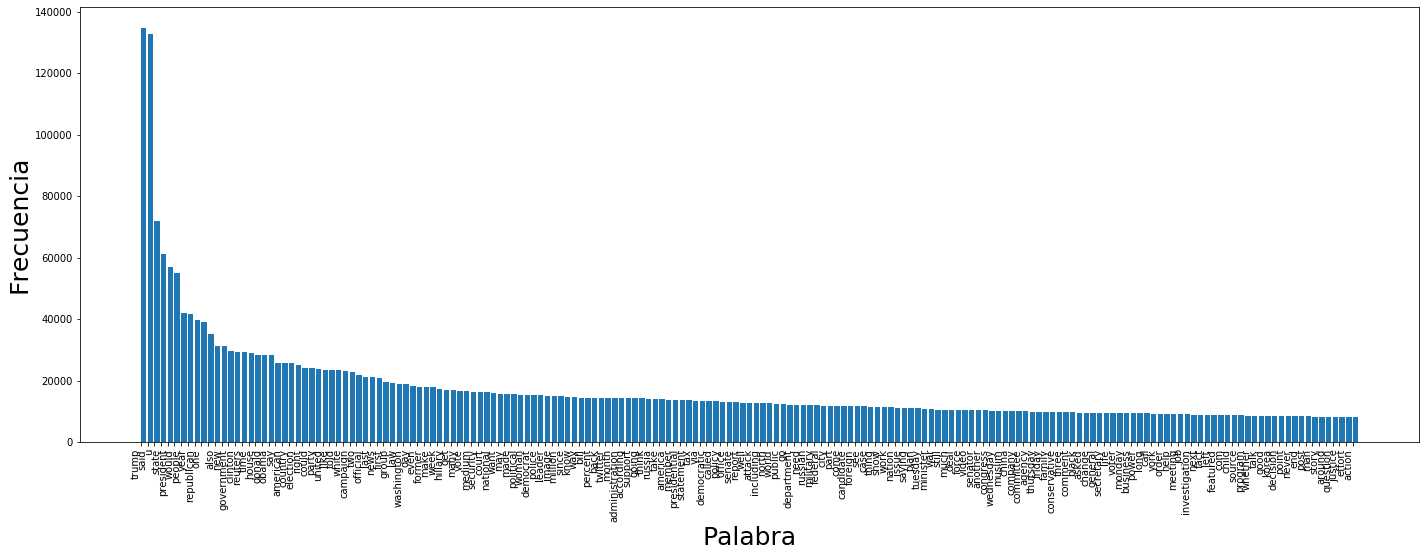

In [12]:
# Histograma de todas las palabras
plt.figure(figsize=[24,8])
plt.bar(keys, values, align='edge')
plt.xlabel('Palabra', size=25)
plt.ylabel('Frecuencia', size=25)
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.savefig("histogram_matplotlib_descending_order_Python.png")
plt.show()

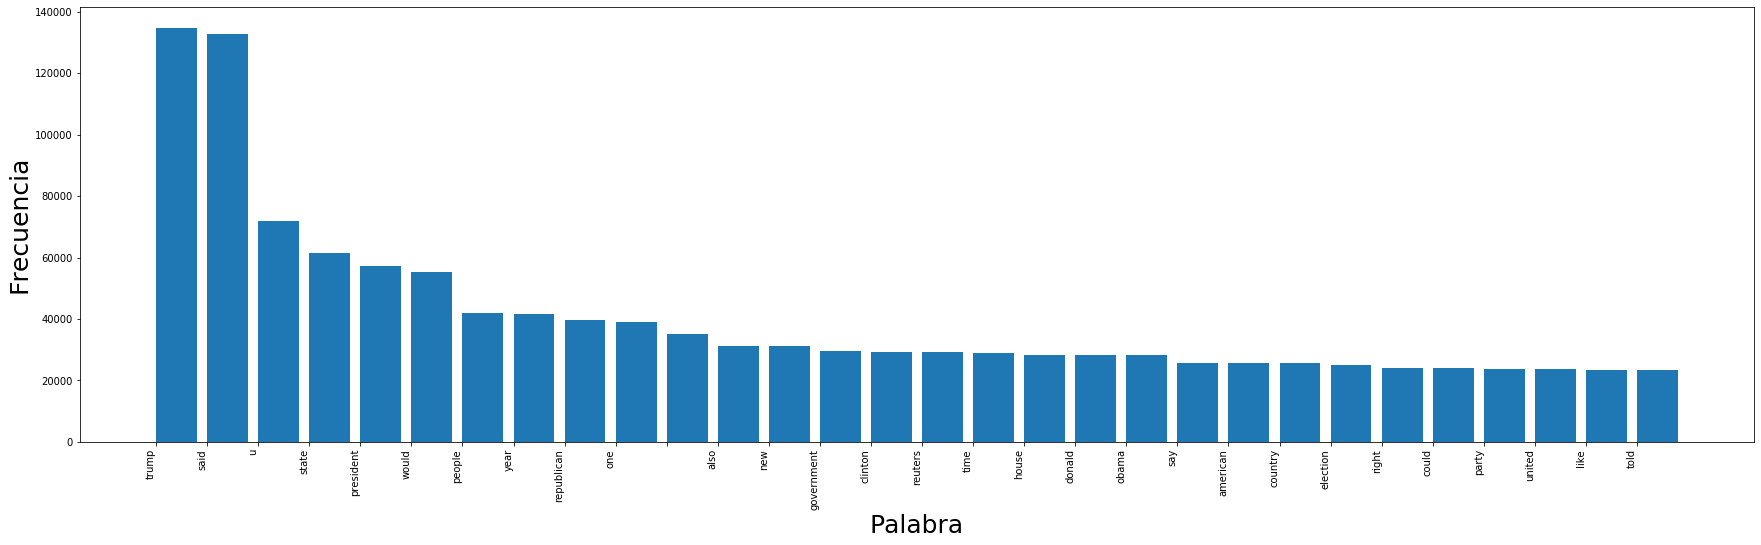

In [13]:
# Para apreciar mejor el contenido, mostramos top 30 overall de todas las palabras

plt.figure(figsize=[30,8])
plt.bar(keys[:30], values[:30], align='edge')
plt.xlabel('Palabra', size=25)
plt.ylabel('Frecuencia', size=25)
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.savefig("histogram_matplotlib_descending_order_Python.png")
plt.show()

## Solo por curiosidad, veremos si es similar cuando filtramos el top 30 verdaderas/falsas
## Veamos el histograma de noticias verdaderas

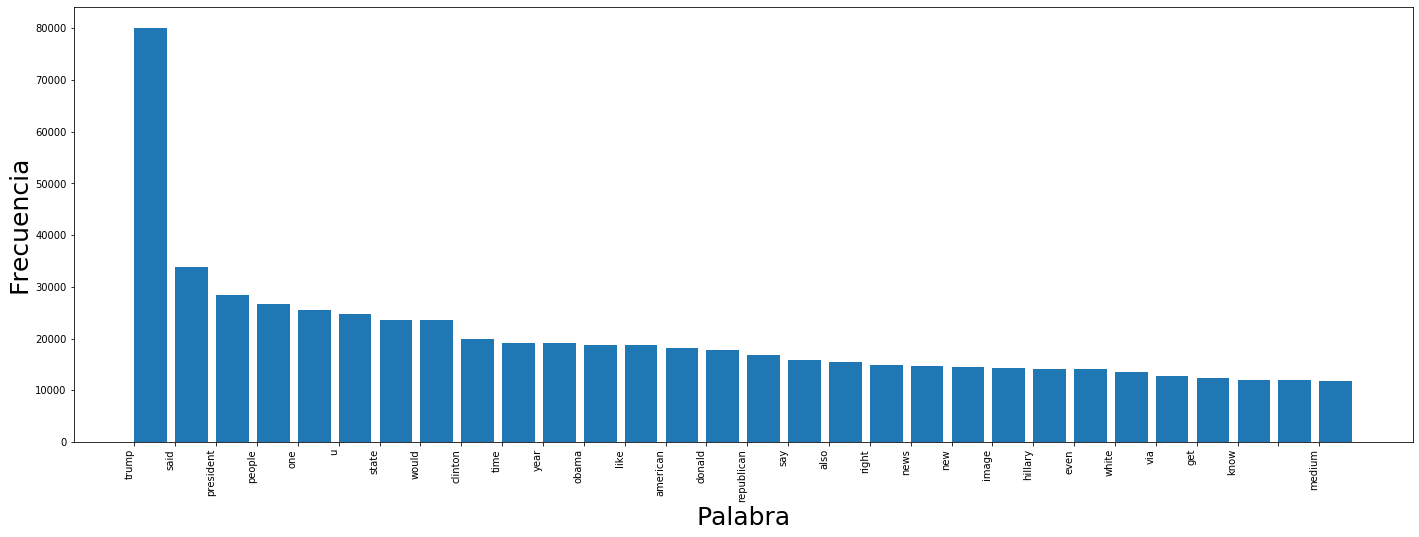

In [14]:
true_news = df.loc[df['label'] == 1]
true_news.head()

true_words = {}
for row in true_news['text_tokenize']:
    for w in row:
        if not w in true_words:
            true_words[w] = 1
        else:
            true_words[w] += 1
true_words = sorted(true_words.items(), key= operator.itemgetter(1), reverse=True)


true_keys, true_values = [], []
true_all_art = []
for k, v in true_words:
    if v >= 8000:
        true_keys.append(k)
        true_values.append(v)

for row in true_news['text_tokenize']:
    article = []
    for wrd in row:
        if wrd in keys:
            article.append(wrd)
    true_all_art.append(' '.join(article))


# Palabras Verdaderas
plt.figure(figsize=[24,8])
plt.bar(true_keys[:30], true_values[:30], align='edge')
plt.xlabel('Palabra', size=25)
plt.ylabel('Frecuencia', size=25)
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.savefig("true_histogram_matplotlib_descending_order_Python.png")
plt.show()

## Ahora el top 30 falsas

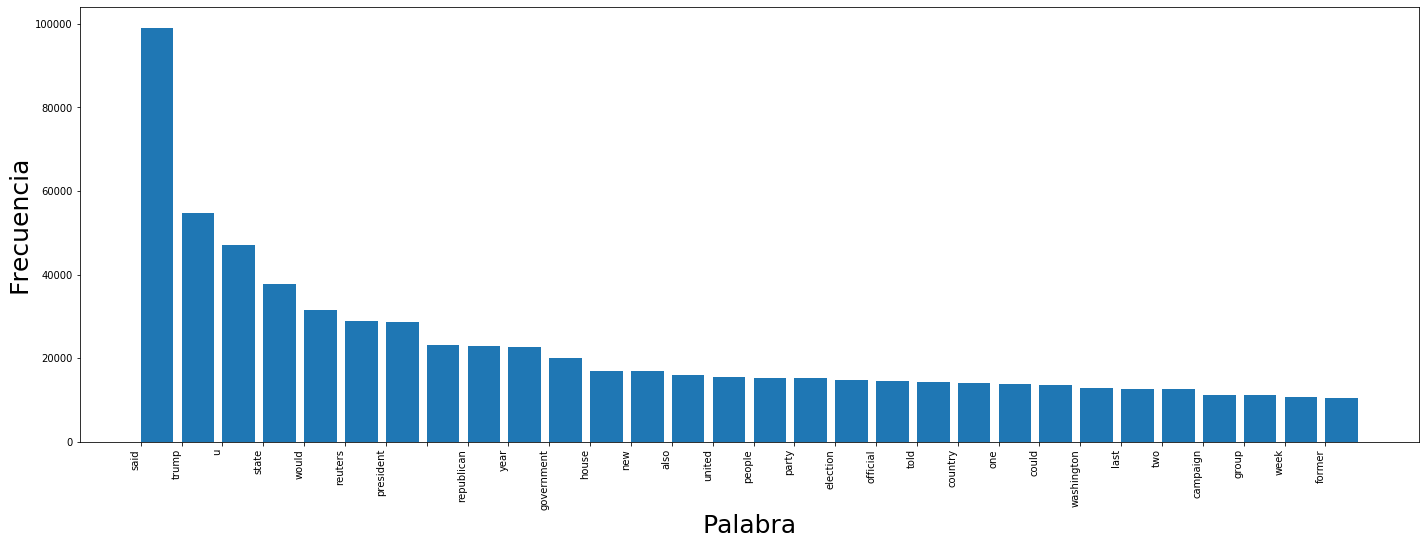

In [15]:
false_news = df.loc[df['label'] == 0]
false_words = {}
for row in false_news['text_tokenize']:
    for w in row:
        if not w in false_words:
            false_words[w] = 1
        else:
            false_words[w] += 1

false_words = sorted(false_words.items(), key= operator.itemgetter(1), reverse=True)

false_keys, false_values = [], []
false_all_art = []
for k, v in false_words:
    if v >= 8000:
        false_keys.append(k)
        false_values.append(v)

for row in false_news['text_tokenize']:
    article = []
    for wrd in row:
        if wrd in keys:
            article.append(wrd)
    false_all_art.append(' '.join(article))


# Palabras Verdaderas
plt.figure(figsize=[24,8])
plt.bar(false_keys[:30], false_values[:30], align='edge')
plt.xlabel('Palabra', size=25)
plt.ylabel('Frecuencia', size=25)
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.savefig("false_histogram_matplotlib_descending_order_Python.png")
plt.show()


**Podemos apreciar que existe traslape entre el top 30 verdadero, falso y overall, con ciertas diferencias en frecuencia cuando filtramos por veracidad. Los valores maximos se mantienen, pero el intermedio cambia según el valor de la noticia.**

**Es curioso que en el histograma de noticias falsas, 'said' tenga más ocurrencias que 'trump', que suele ser la mayor palabra en todo el dataset.**

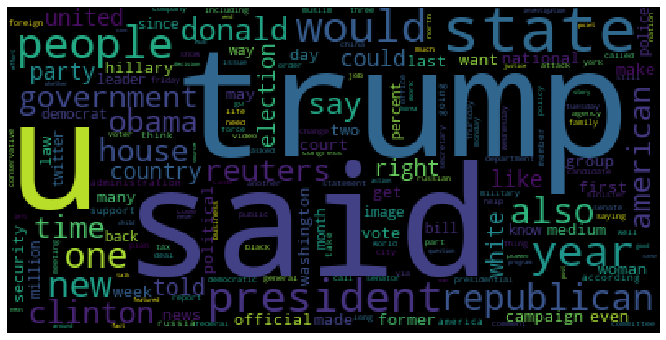

In [16]:
# bonus track entretenido que encontre en https://medium.com/@Genyunus/detecting-fake-news-with-nlp-c893ec31dee8
# lo encontre mas util que el histograma asi que lo agregue

all_words = []
for text in keys:
    all_words.append(text.split())
    
words = [j for i in all_words for j in i]
fdist = FreqDist(words)
# print(fdist.most_common(20))

plt.figure(figsize=(15,6))
wordcloud = WordCloud().generate_from_frequencies(fdist)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# AC02: Explicación procesamiento y proyección a feature space numérico


Los pasos que hemos seguido para preprocesar los datos:

- Leer CSVs
- Eliminar nulos
- Taggear según Noticia Verdadera o Falsa
- Filtrar Stopwords y ruido como caracteres no alfabeticos
- Pasar a minuscula


Vemos que la mayoria de las palabras tienen relacion con politica estadounidense, debido a que vemos palabras como 'trump', 'washington, 'republican', 'government', entre otras. Eso nos hace preguntarnos si nuestro procesamiento y embedding servirá para noticias de otra índole, o causará problemas.

Vemos también que existe una muy alta frecuencia de ciertas palabras, mientras que el resto tiene una comparativamente más pequeña. Esto podría crear overfitting y podreia afectar nuestra predicción al contener un sesgo importante entre la relación de esas palabras con su valor 'label'.

Lo que realizaremos ahora será pasar de texto a un feature space númerico, utilizando las técnicas Bag of Words, Word2Vec y Bert.


- **Bert**

BERT: Bidirectional Encoder Representations from Transformers, un modelo de aprendizaje de características en texto (feature learning) basado en técnicas de aprendizaje profundo.

- **Bag of Words**

Se construye un array de frecuencias de las distintas palabras de cada texto que se desea codificar. Los vectores serán la frecuencia con que aparece cada palabra. Para lograr esto, previamente debemos obtener todas las palabras distintas que aparecen en el set de entrenamiento. Luego, el vector de características tendrá dimensión igual a la cantidad de palabras distintas en el set de entrenamiento. Esto quiere decir que al aplicar la transformación a vectores de las frases, si una palabra del set de validación o set de test no aparece en el set de entrenamiento, entonces esa palabra será información perdida.

CountVectorizer de sklearn nos retorna una sparse matrix al transformar una frase, una representación de las palabras que contiene dicha frase en una estructura que tiene una gran cantidad de ceros. Por esto, se puede ver representada por varias tuplas (pares) que indican la dirección en el vocabulario del CountVectorizer (obtenido desde el set de entrenamiento) y la cantidad de veces que se repite cada palabra de la frase original.


- **Word2Vec**

Transforma cada palabra de un texto a un vector de características, que en la práctica ha resultado ser muy informativo.

En esta técnica tenemos ciertos parametros que podemos elegir.
Algunos de estos son:

   - **num_features**: dimensionalidad del vector de palabras.                     
   - **min_word_count**: conteo minimo que debe tener una palabra.                        
   - **num_workers**: threads que usaremos para correr en paralelo.
   - **context**: tamanho de ventana de contexto.   
   - **downsampling**: setting de downsample para palabras frecuentes.
    
Si bien nos guiamos por las recomendaciones del ayudante, jugamos un poco con estos parametros revisando si habian mejoras en nuestros modelos. Los valores fijados son lo mejor que obtuvimos sin tener un excesivo tiempo de cómputo.


Ahora que ya preprocesamos nuestra BD, estamos listos para transformar estos textos a **feature space numérico**

### Word2Vec

In [17]:
# Defino los nucleos para el multiproceso
# Generamos un embedding utilizando solo el set de train, pero obtuvimos
# resultados por debajo de lo esperado (~50%), por lo que generamos el embedding con todo
# el dataset, para luego generar el embedding del set de test.

tokens = df['text_tokenize']
cores = multiprocessing.cpu_count()
w2v = Word2Vec(min_count=20, 
               window=2, 
               size=100, 
               sample=6e-5,
               alpha=0.03, 
               min_alpha=0.0007, 
               negative=5, 
               workers=cores-1)

# Creando el vocabulario
w2v.build_vocab(list(tokens), progress_per=10000)

# Train
w2v.train(list(tokens), 
          total_examples=w2v.corpus_count, 
          epochs=50, 
          report_delay=1)


# Embedding Train
all_embd = []
for k, text in enumerate(tokens):
    embedding = []
    for w in text:
        try:
            embedding.append(w2v.wv[w])
        except KeyError as error:
            pass
            # print(error, 'Deprecada')
    all_embd.append(embedding)
    
df['embedding'] = all_embd

In [18]:
# train_df.head(5)

In [19]:
# normalizar

large = []
for i,a in enumerate(df['embedding']):
    large.append(np.sum(a,axis=0))

    
X_w2v_per_feat = normalize(large, axis=0)
X_w2v_per_obs = normalize(large, axis=1)

In [20]:
X_w2v_per_feat

array([[ 3.02505978e-03, -8.39755270e-04,  2.06515236e-03, ...,
         2.52841569e-03, -8.23943594e-05,  2.48970132e-04],
       [ 1.06535904e-03,  3.00563671e-03, -4.94180244e-03, ...,
        -8.33825543e-03, -9.05156753e-03, -9.01028328e-03],
       [-1.16394194e-03, -2.13967471e-03, -5.41593622e-04, ...,
         6.91121460e-04, -1.25231834e-03, -1.07162442e-03],
       ...,
       [-9.87948728e-04, -1.69175974e-03,  5.57387077e-03, ...,
         1.60859266e-03,  1.98581938e-03,  8.39051359e-03],
       [-9.30370715e-04, -7.30126373e-04, -1.81651812e-03, ...,
        -7.39436654e-03, -7.63180387e-03,  1.20900782e-02],
       [-2.81682103e-04,  8.39482910e-04,  1.67933571e-04, ...,
        -2.30658354e-04,  4.09914184e-04, -1.31394554e-03]])

In [21]:
X_w2v_per_obs

array([[ 0.10716626, -0.03212991,  0.06285664, ...,  0.0809201 ,
        -0.00313425,  0.00841947],
       [ 0.01208623,  0.0368268 , -0.04816762, ..., -0.08545823,
        -0.11026307, -0.09757685],
       [-0.06913522, -0.1372614 , -0.02763863, ...,  0.03708568,
        -0.07987194, -0.06076089],
       ...,
       [-0.02887116, -0.05339507,  0.13994639, ...,  0.0424678 ,
         0.06231334,  0.23406252],
       [-0.01182643, -0.01002371, -0.01983866, ..., -0.08491461,
        -0.10416846,  0.14670341],
       [-0.01877788,  0.06044102,  0.00961833, ..., -0.01389122,
         0.02934213, -0.08361383]])

In [ ]:
warnings.filterwarnings("ignore")
stop = stopwords.words('english')
text_tokenize_test, text_cleanned_test = [], []
for i, text in enumerate(test_df['text']):
    new_text = re.sub('[^a-zA-Z]+',' ', text)
    new_text = new_text.lower()
    new_text = [word for word in new_text.split(sep=' ') if not word in stop]
    new_text = [Word(word).lemmatize() for word in new_text]
    text_tokenize_test.append(new_text)
    text_cleanned_test.append(" ".join(new_text))
    
test_df['text_tokenize'] = text_tokenize_test
test_df['text_cleanned'] = text_cleanned_test

In [ ]:
# Embedding set de Test
warnings.filterwarnings("ignore")
all_embd_test = []
for k, text in enumerate(test_df['text_tokenize']):
    embedding = []
    for w in text:
        try:
            embedding.append(w2v.wv[w])
        except KeyError as error:
            pass
            # print(error, 'Deprecada')
    all_embd_test.append(embedding)
    
test_df['embedding'] = all_embd_test

In [26]:
# normalizacion embbeding set test

large_test =[]
for i,a in enumerate(test_df['embedding']):
    large_test.append(np.sum(a,axis=0))

X_w2v_per_feat_test = normalize(large_test, axis=0)
X_w2v_per_obs_test = normalize(large_test, axis=1)

In [27]:
X_w2v_per_feat_test

array([[ 0.0040263 , -0.00019709, -0.00483146, ..., -0.00231701,
         0.00118441, -0.00414834],
       [ 0.00391841, -0.01513997,  0.00726939, ...,  0.00396705,
         0.00267255,  0.02304733],
       [ 0.00055145, -0.00043085,  0.00093437, ..., -0.00186528,
         0.00068737, -0.00060218],
       ...,
       [ 0.00723417, -0.00145444,  0.00461174, ...,  0.00013215,
         0.00498048,  0.01878358],
       [ 0.00041976, -0.00108537,  0.00164323, ..., -0.00246267,
         0.00144629, -0.00071255],
       [ 0.00205061,  0.00275613,  0.00254314, ..., -0.00365265,
        -0.00793187, -0.01134227]])

In [28]:
X_w2v_per_obs_test

array([[ 0.05026523, -0.00286299, -0.05371426, ..., -0.02944737,
         0.01790998, -0.05364469],
       [ 0.03167649, -0.14241292,  0.05233297, ...,  0.03264765,
         0.02616897,  0.19299189],
       [ 0.02172748, -0.01975275,  0.03278467, ..., -0.07481783,
         0.03280396, -0.02457666],
       ...,
       [ 0.08275301, -0.01935923,  0.04697968, ...,  0.00153894,
         0.06900804,  0.22256904],
       [ 0.01541679, -0.04638372,  0.05374479, ..., -0.09207719,
         0.06433932, -0.02710801],
       [ 0.03168766,  0.04955693,  0.03499679, ..., -0.05746084,
        -0.14846226, -0.18155098]])

### Bag of Words

In [29]:
vectorizer = CountVectorizer(ngram_range=(1,1))
x_bow_fit = vectorizer.fit(all_art)
bow_emb = vectorizer.transform(all_art)
bow_emb.toarray().shape

(44898, 179)

In [30]:
# Reduccion dim
clf = TruncatedSVD(100)
bow_emb_100 = clf.fit_transform(bow_emb)

In [31]:
bow_emb_100

array([[ 3.86836716e+00,  1.58113292e+00, -7.27164710e-01, ...,
         5.12108668e-03,  2.99563777e-01,  7.56980204e-02],
       [ 1.27326688e+01,  7.35264150e+00,  1.23543664e-01, ...,
         4.85697810e-01,  6.37487626e-01, -1.46238809e-01],
       [ 1.40432751e+00,  1.05642187e+00, -2.40585061e-01, ...,
         1.23727565e-01,  8.18319959e-02,  4.79274826e-01],
       ...,
       [ 1.31865710e+01, -9.29461951e+00, -2.45711569e+00, ...,
        -5.54635855e-01,  1.18970652e+00, -1.47033014e-01],
       [ 1.50061903e+01,  9.53157821e+00,  2.74368035e+00, ...,
         1.15007079e+00, -2.57121392e-01, -1.18438412e+00],
       [ 1.34117647e+00,  1.08926833e+00, -6.70979678e-01, ...,
        -2.62493549e-02, -1.78719999e-01,  3.59928103e-01]])

### BERT

Computamos los archivos entregados por ayudante.

In [42]:
ft_bert = np.load('feat_bert3.npy')
ft_bert.shape

(43404, 768)

In [43]:
labels_bert = np.load('labels3.npy')
#labels
labels_bert.shape

(43404,)

# AC03: SVM



Teniendo ya el embedding necesario, procederemos a implementar e utilizar los clasificadores SVM y Random Forest. Comenzaremos por SVM.

La idea detras de SVM es que, dado un conjunto de puntos, subconjunto de un conjunto mayor (espacio), en el que cada uno de ellos pertenece a una de dos posibles categorías, un algoritmo basado en SVM construye un modelo capaz de predecir si un punto nuevo (cuya categoría desconocemos) pertenece a una categoría o a la otra.

Como en la mayoría de los métodos de clasificación supervisada, los datos de entrada (los puntos) son vistos como un vector p-dimensional (una lista ordenada de p números).

### SVM + Bag of Words

In [101]:
# Dividiendo el dataset para usar BoW
X_bow, X_test_bow, y_bow, y_test_bow = train_test_split(bow_emb_100, 
                                                        np.array(labels_), 
                                                        shuffle=False, 
                                                        test_size=0.2)

# Generando el set de train y validacion
X_train_bow, X_val_bow, y_train_bow, y_val_bow = train_test_split(X_bow, 
                                                                  y_bow, 
                                                                  shuffle=False, 
                                                                  test_size=0.2)

In [92]:
# Training set

kernels = ['linear', 'poly', 'rbf']
C = [100, 10, 1.0, 0.5, 0.1]

for k in kernels:
    for c in C:
        svm = SVC(C=c, kernel=k, gamma="scale")
        svm.fit(X_train_bow, y_train_bow)
        y_pred_val_bow = svm.predict(X_train_bow)
        print('kernel:', k, 'C:',c,'accuracy:', (sum(y_pred_val_bow == y_train_bow)/len(y_pred_val_bow)*100), '%')

kernel: linear C: 100 accuracy: 98.02324772047052 %
kernel: linear C: 10 accuracy: 98.05456949954757 %
kernel: linear C: 1.0 accuracy: 98.04760910419712 %
kernel: linear C: 0.5 accuracy: 98.01628732512006 %
kernel: linear C: 0.1 accuracy: 98.02672791814575 %
kernel: poly C: 100 accuracy: 98.18333681353101 %
kernel: poly C: 10 accuracy: 96.16830235957401 %
kernel: poly C: 1.0 accuracy: 91.76237210273544 %
kernel: poly C: 0.5 accuracy: 88.92253079974942 %
kernel: poly C: 0.1 accuracy: 83.14888285654625 %
kernel: rbf C: 100 accuracy: 99.98607920929908 %
kernel: rbf C: 10 accuracy: 99.91995545346975 %
kernel: rbf C: 1.0 accuracy: 99.30396046495441 %
kernel: rbf C: 0.5 accuracy: 98.99074267418389 %
kernel: rbf C: 0.1 accuracy: 97.42117352265609 %


In [102]:
# Validacion 


kernels = ['linear', 'poly', 'rbf']
C = [10, 1.0, 0.5, 0.1]

for k in kernels:
    for c in C:
        svm = SVC(C=c, kernel=k, gamma="scale")
        svm.fit(X_train_bow, y_train_bow)
        y_pred_val_bow = svm.predict(X_val_bow)
        print('kernel:', k, 'C:',c,'accuracy:', (sum(y_pred_val_bow == y_val_bow)/len(y_pred_val_bow)*100), '%')

kernel: linear C: 10 accuracy: 97.96770601336303 %
kernel: linear C: 1.0 accuracy: 97.93986636971047 %
kernel: linear C: 0.5 accuracy: 97.93986636971047 %
kernel: linear C: 0.1 accuracy: 97.9259465478842 %
kernel: poly C: 10 accuracy: 94.61302895322939 %
kernel: poly C: 1.0 accuracy: 90.74331848552339 %
kernel: poly C: 0.5 accuracy: 88.0707126948775 %
kernel: poly C: 0.1 accuracy: 82.40534521158129 %
kernel: rbf C: 10 accuracy: 98.48273942093542 %
kernel: rbf C: 1.0 accuracy: 98.10690423162583 %
kernel: rbf C: 0.5 accuracy: 97.88418708240535 %
kernel: rbf C: 0.1 accuracy: 96.39476614699332 %


## SVM + W2V

In [103]:
#SVM con Word2Vec con normalizacion por feature

X_w2v, X_test_w2v, y_w2v, y_test_w2v = train_test_split(X_w2v_per_feat, 
                                                        labels_, 
                                                        shuffle=False, 
                                                        test_size=0.2)

X_train_w2v, X_val_w2v, y_train_w2v, y_val_w2v = train_test_split(X_w2v, 
                                                                  y_w2v, 
                                                                  shuffle=False, 
                                                                  test_size=0.2)

In [104]:
# Train 

kernels = ['linear', 'poly', 'rbf']
C = [10, 1.0, 0.5, 0.1]

for k in kernels:
    for c in C:
        svm = SVC(C=c, kernel=k, gamma="scale")
        svm.fit(X_train_w2v, y_train_w2v)
        y_pred_val_w2v = svm.predict(X_val_w2v)
        print('kernel:', k, 'C:',c,'accuracy:', (sum(y_pred_val_w2v == y_train_w2v)/len(y_pred_val_w2v)*100), '%')
        

kernel: linear C: 10 accuracy: 94.67877775457646 %
kernel: linear C: 1.0 accuracy: 91.13593652119441 %
kernel: linear C: 0.5 accuracy: 87.46084777615368 %
kernel: linear C: 0.1 accuracy: 66.91376070160786 %
kernel: poly C: 10 accuracy: 52.028955244657894 %
kernel: poly C: 1.0 accuracy: 52.028955244657894 %
kernel: poly C: 0.5 accuracy: 52.028955244657894 %
kernel: poly C: 0.1 accuracy: 52.028955244657894 %
kernel: rbf C: 10 accuracy: 95.67411428969166 %
kernel: rbf C: 1.0 accuracy: 94.00013920790701 %
kernel: rbf C: 0.5 accuracy: 93.20317394027981 %
kernel: rbf C: 0.1 accuracy: 86.07224890373773 %


In [105]:
# Validation

kernels = ['linear', 'poly', 'rbf']
C = [10, 1.0, 0.5, 0.1]

for k in kernels:
    for c in C:
        svm = SVC(C=c, kernel=k, gamma="scale")
        svm.fit(X_train_w2v, y_train_w2v)
        y_pred_val_w2v = svm.predict(X_train_w2v)
        print('kernel:', k, 'C:',c,'accuracy:', (sum(y_pred_val_w2v == y_train_w2v)/len(y_pred_val_w2v)*100), '%')
        

kernel: linear C: 10 accuracy: 94.67877775457646 %
kernel: linear C: 1.0 accuracy: 91.13593652119441 %
kernel: linear C: 0.5 accuracy: 87.46084777615368 %
kernel: linear C: 0.1 accuracy: 66.91376070160786 %
kernel: poly C: 10 accuracy: 52.028955244657894 %
kernel: poly C: 1.0 accuracy: 52.028955244657894 %
kernel: poly C: 0.5 accuracy: 52.028955244657894 %
kernel: poly C: 0.1 accuracy: 52.028955244657894 %
kernel: rbf C: 10 accuracy: 95.67411428969166 %
kernel: rbf C: 1.0 accuracy: 94.00013920790701 %
kernel: rbf C: 0.5 accuracy: 93.20317394027981 %
kernel: rbf C: 0.1 accuracy: 86.07224890373773 %


In [106]:
#SVM con Word2Vec con normalizacion por observacion o texto

X_w2v, X_test_w2v, y_w2v, y_test_w2v = train_test_split(X_w2v_per_obs, 
                                                        labels_, 
                                                        shuffle=False, 
                                                        test_size=0.2)

X_train_w2v, X_val_w2v, y_train_w2v, y_val_w2v = train_test_split(X_w2v, 
                                                                  y_w2v, 
                                                                  shuffle=False, 
                                                                  test_size=0.2)

In [107]:
# Train

kernels = ['linear', 'poly', 'rbf']
C = [10, 1.0, 0.5, 0.1]

for k in kernels:
    for c in C:
        svm = SVC(C=c, kernel=k, gamma="scale")
        svm.fit(X_train_w2v, y_train_w2v)
        y_pred_val_w2v = svm.predict(X_train_w2v)
        print('kernel:', k, 'C:',c,'accuracy:', (sum(y_pred_val_w2v == y_train_w2v)/len(y_pred_val_w2v)*100), '%')
        

kernel: linear C: 10 accuracy: 96.3771142200877 %
kernel: linear C: 1.0 accuracy: 96.37015382473724 %
kernel: linear C: 0.5 accuracy: 96.37015382473724 %
kernel: linear C: 0.1 accuracy: 96.05693603396674 %
kernel: poly C: 10 accuracy: 94.13586691724089 %
kernel: poly C: 1.0 accuracy: 90.85056031182572 %
kernel: poly C: 0.5 accuracy: 87.08150622955384 %
kernel: poly C: 0.1 accuracy: 52.028955244657894 %
kernel: rbf C: 10 accuracy: 97.31328739472403 %
kernel: rbf C: 1.0 accuracy: 96.42583698754089 %
kernel: rbf C: 0.5 accuracy: 96.19614394097584 %
kernel: rbf C: 0.1 accuracy: 95.30521333611749 %


In [108]:
# Validation


kernels = ['linear', 'poly', 'rbf']
C = [10, 1.0, 0.5, 0.1]

for k in kernels:
    for c in C:
        svm = SVC(C=c, kernel=k, gamma="scale")
        svm.fit(X_train_w2v, y_train_w2v)
        y_pred_val_w2v = svm.predict(X_val_w2v)
        print('kernel:', k, 'C:',c,'accuracy:', (sum(y_pred_val_w2v == y_val_w2v)/len(y_pred_val_w2v)*100), '%')
        

kernel: linear C: 10 accuracy: 96.3390868596882 %
kernel: linear C: 1.0 accuracy: 96.42260579064587 %
kernel: linear C: 0.5 accuracy: 96.39476614699332 %
kernel: linear C: 0.1 accuracy: 96.21380846325167 %
kernel: poly C: 10 accuracy: 94.44599109131403 %
kernel: poly C: 1.0 accuracy: 91.43930957683742 %
kernel: poly C: 0.5 accuracy: 87.40256124721604 %
kernel: poly C: 0.1 accuracy: 52.28285077951003 %
kernel: rbf C: 10 accuracy: 96.96547884187082 %
kernel: rbf C: 1.0 accuracy: 96.39476614699332 %
kernel: rbf C: 0.5 accuracy: 96.25556792873051 %
kernel: rbf C: 0.1 accuracy: 95.65701559020044 %


## SVM + BERT

In [46]:
ft_bert

array([[-0.11887352, -0.52489644, -0.93963856, ..., -0.7726385 ,
        -0.3475276 , -0.10354795],
       [-0.4680108 , -0.5591215 , -0.9686077 , ..., -0.74598026,
        -0.60172594,  0.3425974 ],
       [-0.6194068 , -0.64621276, -0.91207623, ..., -0.5501844 ,
        -0.60456306,  0.27381653],
       ...,
       [-0.68827   , -0.66322875, -0.9742782 , ..., -0.799391  ,
        -0.74067175,  0.2702311 ],
       [-0.32522142, -0.59307283, -0.97849447, ..., -0.86737204,
        -0.53682035, -0.33102667],
       [-0.7650314 , -0.674678  , -0.9800001 , ..., -0.8735728 ,
        -0.64572424,  0.2785621 ]], dtype=float32)

In [47]:
labels_bert

array([0, 1, 0, ..., 1, 1, 0])

In [113]:
#SVM con Word2Vec con normalizacion por observacion o texto

X_bert_obs, X_test_bert, y_bert_obs, y_test_bert = train_test_split(ft_bert, 
                                                                    labels_bert, 
                                                                    shuffle=False, 
                                                                    test_size=0.2)

X_train_bert, X_val_bert, y_train_bert, y_val_bert = train_test_split(X_bert_obs, 
                                                                  y_bert_obs, 
                                                                  shuffle=False, 
                                                                  test_size=0.2)

In [93]:
# Training

kernels = ['linear', 'poly', 'rbf']
C = [100, 10, 1.0, 0.5, 0.1]
for k in kernels:
    for c in C:
        svm = SVC(C=c, kernel=k, gamma="scale")
        svm.fit(X_train_bert, y_train_bert)
        y_pred_val_bert = svm.predict(X_train_bert)
        print('kernel:', k, 'C:',c,'accuracy:', (sum(y_pred_val_bert == y_train_bert)/len(y_pred_val_bert)*100), '%')
        

kernel: linear C: 100 accuracy: 99.89920080639355 %
kernel: linear C: 10 accuracy: 99.65440276477788 %
kernel: linear C: 1.0 accuracy: 99.3376052991576 %
kernel: linear C: 0.5 accuracy: 99.18280653754769 %
kernel: linear C: 0.1 accuracy: 98.61401108791131 %
kernel: poly C: 100 accuracy: 99.22960616315069 %
kernel: poly C: 10 accuracy: 98.14241486068111 %
kernel: poly C: 1.0 accuracy: 96.78882568939449 %
kernel: poly C: 0.5 accuracy: 96.25962992296063 %
kernel: poly C: 0.1 accuracy: 94.78364173086615 %
kernel: rbf C: 100 accuracy: 99.32680538555691 %
kernel: rbf C: 10 accuracy: 98.40881272949817 %
kernel: rbf C: 1.0 accuracy: 97.23522211822305 %
kernel: rbf C: 0.5 accuracy: 96.7672258621931 %
kernel: rbf C: 0.1 accuracy: 95.68363453092375 %


In [110]:
# Validacion 

kernels = ['linear', 'poly', 'rbf']
C = [100, 10, 1.0, 0.5, 0.1]

for k in kernels:
    for c in C:
        svm = SVC(C=c, kernel=k, gamma="scale")
        svm.fit(X_train_bert, y_train_bert)
        y_pred_val_bert = svm.predict(X_val_bert)
        print('kernel:', k, 'C:',c,'accuracy:', (sum(y_pred_val_bert == y_val_bert)/len(y_pred_val_bert)*100), '%')
        

kernel: linear C: 100 accuracy: 98.79049676025919 %
kernel: linear C: 10 accuracy: 98.89128869690424 %
kernel: linear C: 1.0 accuracy: 99.06407487401007 %
kernel: linear C: 0.5 accuracy: 99.02087832973362 %
kernel: linear C: 0.1 accuracy: 98.56011519078474 %
kernel: poly C: 100 accuracy: 99.00647948164148 %
kernel: poly C: 10 accuracy: 98.01295896328294 %
kernel: poly C: 1.0 accuracy: 96.47228221742262 %
kernel: poly C: 0.5 accuracy: 95.9251259899208 %
kernel: poly C: 0.1 accuracy: 94.73002159827215 %
kernel: rbf C: 100 accuracy: 99.06407487401007 %
kernel: rbf C: 10 accuracy: 98.34413246940244 %
kernel: rbf C: 1.0 accuracy: 97.10583153347733 %
kernel: rbf C: 0.5 accuracy: 96.73146148308135 %
kernel: rbf C: 0.1 accuracy: 95.63714902807774 %



- **¿Qué significa el parámetro C?**

$C$ **es la constante de penalizacion asociada a las variables slack**. Mientras mayor es $C$, menor es la susceptibilidad a clases mal clasificadas.
Controla el trade off entre la decisión de un limite "smooth" y clasificar puntos de entrenamiento correctamente. Como ya mencionabamos, un C alto significará que tendremos una penalización alta a los errores de clasificación (Low bias, high variance)

- **¿Cómo afectan estos cambios al rendimiento del clasificador en el conjunto de entrenamiento y validación?**

RBF: Radial Basis Function kernel. Este transformador/procesador genera nuevas features al medir la distancia entre todos los otros puntos a un/unos puntos epicentro. Por ejemplo, puede usar un centro radial gaussiano.


Poly: Polynomial Kernel. Transforma/procesa para generar nuevas features al aplicar combinacion polinomial a todas las existentes.

Linear: Se utiliza cuando la data es linearmente separable en el hiperplano por una linea recta, Se utiliza normalmente cuando hay un gran numero de features. Suele ser mas rapido que los otros.


**Presentación de resultados en tablas**. Como hice muchos experimentos, he truncado los valores que eran iguales. Es decir, si el numero de "C" no incidia en más de un 0.1% de ganancia de accuray, dejamos de reportar para los C's siguientes. Esto no ocurría mucho, generalmente solo en el salto de 10 a 100 Cs. Ademas, en SVM calculamos tanto normalizado por feature y por observación, pero presentamos solo el que obtuvo maximos (por observación)


## BoW

- Training set

C | linear | poly | rbf
--- | --- | --- | ---
0.1 | 98.02  | 83.14 | 97.42
0.5 | 98.01  | 88.92 | 98.99
1 | 98.04 | 91.76 | 99.30
10 | 98.05 | 96.16 | 99.91
100 | 98.02 | 98.18 | 99.98


- Validation set

C | linear | poly | rbf
--- | --- | --- | ---
0.1 | 97.92  | 82.40 | 96.39
0.5 | 97.93  | 88.07 | 97.88
1 | 97.93 | 90.74 | 98.10
10 | 97.96 | 94.61 | 98.48


## W2V + Normalizacion por feature

- Se omite tabla ya que los maximos fueron via Observacion. Se presentan los resultados más arriba. 

## W2V + Normalizacion por Obs

- Training set

C | linear | poly | rbf
--- | --- | --- | ---
0.1 | 96.05  | 52.02 | 96.19
0.5 | 96.37  | 87.08 | 96.19
1 | 96.37 | 90.85 | 96.42
10 | 96.37 | 94.13 | 97.31


- Validation set

C | linear | poly | rbf
--- | --- | --- | ---
0.1 | 96.21  | 52.28 | 95.65
0.5 | 96.39  | 87.40 | 96.25
1 | 96.42 | 91.43 | 96.39
10 | 96.33 |  94.44 | 96.96

## BERT

- Training set

C | linear | poly | rbf
--- | --- | --- | ---
0.1 |  98.61  | 94.78 | 95.06
0.5 | 99.18  | 96.25 | 96.76
1 | 99.33 | 96.78 | 97.23
10 | 99.65 | 98.14 | 98.40
100 | 99.89 | 99.22 | 99.32


- Validation set

C | linear | poly | rbf
--- | --- | --- | ---
0.1 | 98.56  | 94.73 | 95.36
0.5 | 99.02  | 95.92 | 96.73
1 | 99.0 | 96.47 | 97.10
10 |  98.89 | 98.01 | 98.34
100 | 98.79 | 99.00 | 99.06



- **¿Mejor rendimiento en los conjuntos de train?** 

Los mejores resultados fueron presentados por BERT y BoW.

- **¿Mejor rendimiento en los conjuntos de validación?** 

Aquí BERT se impuso fuertemente frente a los otros.



Vemos como el factor C es muy importante en los resultados que tenemos. 
En el kernel lineal vemos que la accuracy suele crecer en conjunto a C, pero también notamos algo interesante: existe un tope. Una vez que el C sigue creciendo, el accuracy baja. Esto se podría deber a que estamos viendo un overfit.

El kernel polinomial presenta los peores rendimientos en general, a pesar de variar su C. La razón de esto es, probablemente, debida a la naturaleza y mezcla de datos.

RDF suele crecer junto a C, presentando grandes saltos una vez que llegamos a un C óptimo. Esto nos hace pensar que RDF es mas sensible al valor de la penalización de clases que los otros tipos.



## AC04: Mejor SVM ?


Como podemos ver en las tablas, **SVM + Bert** presentó los mejores resultados, comparando según rendimientos de set de validacion. Es por esto que elegiremos esta combinación, con los hiperparametros que resultaron más eficientes, para probar nuestro set de test.

In [124]:
# Test set separado al principio

svm = SVC(C=0.5, kernel='linear', gamma="scale")
svm.fit(X_train_bert, y_train_bert)
y_pred_test_bert = svm.predict(X_test_bert)
accuracy_score(y_test_bert, y_pred_test_bert)
        

0.9897477249164843

In [125]:
confusion_matrix(y_test_bert, y_pred_test_bert)

array([[4238,   33],
       [  56, 4354]])

In [134]:
for noticia_idx in range(15):
    print("La noticia: ")
    print(test_df['title'].iloc[noticia_idx])
    print("Tenia un valor real de")
    print(labels_bert[noticia_idx])
    print("Y fue predicha como")
    print(y_pred_test_bert[noticia_idx])
    print("\n")


La noticia: 
 Convicted Felon With A Gun Has Knee-Jerk Reaction That Kills His Own Daughter
Tenia un valor real de
0
Y fue predicha como
1


La noticia: 
 38% Of Trump Supporters Wish South Had Won Civil War And Other Disgusting Findings In New Poll
Tenia un valor real de
1
Y fue predicha como
0


La noticia: 
Russia's Putin signs decree imposing restrictions on North Korea
Tenia un valor real de
0
Y fue predicha como
0


La noticia: 
SMOKING GUN? First FISA Request on Trump Tower Came After Bill Clinton, Obama’s AG Loretta Lynch Had Private Meeting On Plane
Tenia un valor real de
0
Y fue predicha como
0


La noticia: 
UK raises 'grave concerns' about illegal settlements with Israel's Netanyahu: May's office
Tenia un valor real de
0
Y fue predicha como
1


La noticia: 
Russian diplomats vacate three properties on U.S. orders
Tenia un valor real de
1
Y fue predicha como
1


La noticia: 
 Obama And Justin Trudeau Had Dinner Tuesday; For A Moment, The World Felt Sane Again
Tenia un valor 

Observaciones: 

En SVM, vemos como el factor C es muy importante en los resultados que tenemos. En el kernel lineal vemos que la accuracy suele crecer en conjunto a C, pero también notamos algo interesante: existe un tope. Una vez que el C sigue creciendo, el accuracy baja. Esto se podría deber a que estamos viendo un overfit.

El kernel polinomial presenta los peores rendimientos en general, a pesar de variar su C. La razón de esto es, probablemente, debida a la naturaleza y mezcla de datos.

RDF suele crecer junto a C, presentando grandes saltos una vez que llegamos a un C óptimo. Esto nos hace pensar que RDF es mas sensible al valor de la penalización de clases que los otros tipos.

## AC05: Random Forest

Random Forest son un método de clasificación ML que crea múltiples árboles de decisión a medida que va entrenando el modelo. También como '"Bosques Aleatorios"', es una combinación de árboles predictores tal que cada árbol depende de los valores de un vector aleatorio probado independientemente y con la misma distribución para cada uno de estos. Es una modificación sustancial de bagging que construye una larga colección de árboles no correlacionados y luego los promedia.


La idea esencial del bagging es promediar muchos modelos ruidosos pero aproximadamente imparciales, y por tanto reducir la variación. Los árboles son los candidatos ideales para el bagging, dado que ellos pueden registrar estructuras de interacción compleja en los datos, y si crecen suficientemente profundo, tienen relativamente baja parcialidad. Producto de que los árboles son notoriamente ruidosos, ellos se benefician enormemente al promediar.


Cada árbol es construido usando el siguiente algoritmo:

- Sea N el número de casos de prueba, M es el número de variables en el clasificador.
- Sea m el número de variables de entrada a ser usado para determinar la decisión en un nodo dado; m debe ser mucho menor que M
- Elegir un conjunto de entrenamiento para este árbol y usar el resto de los casos de prueba para estimar el error.
- Para cada nodo del árbol, elegir aleatoriamente m variables en las cuales basar la decisión. Calcular la mejor partición del conjunto de entrenamiento a partir de las m variables.


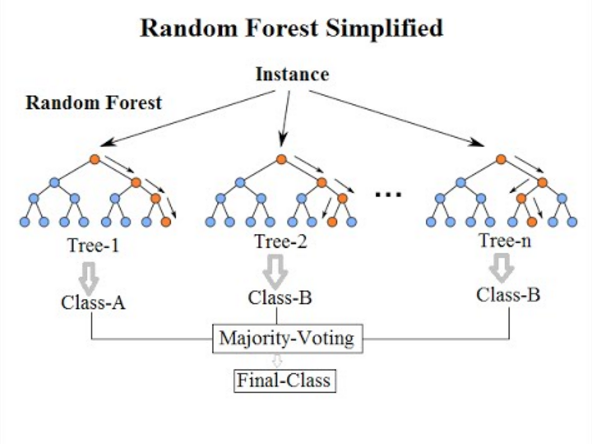

In [86]:
Image(filename = "rfsss.png", width = 600, height = 300)

- **¿Qué determina el parámetro criterion?**

- **criterion**: determina que función será la utilizada para medir la calidad de una división. Puede ser Gini o Entropia. Ambas se utilizan para medir la impureza de un nodo.

    - **Gini**: utiliza la impureza Gini y va de 0 a 0.5. Mide el grado o probabilidad de clasificar mal una variable particular cuando la elegimos aleatoriamente. Qué nos referimos por impureza ? Si todos los elementos corresponden a una clase, entonces puede llamarse pura. El coeficiente va de 0 a 1, en donde 0 denota que todos los elementos pertenecen a cierta clase (o si exite solo una) y 1 dentoa que estan distribuidos entre varias clases. Por ejemplo, Gini = 0.5 denota que los elementos estan distribuidos equitativamente entre todas las clases.
    
    - **Entropia**: utiliza ganancia de información. Va entre 0 y 1. La ganancia de información es la entropia de un nodo padre menos la suma ponderada de las entropias de los nodos hijos. La ponderacion de un nodo hoja es el numero de muestras en el nodo/total numero de muestras de todos los nodos hoja.


- **max_depth**: es la maxima profundidad a la cual llegarán los árboles. Una vez llegado a ese nivel, se construyen los nodos hoja en vez de seguir expandiendo.


- **n_estimator**: cantidad de árboles del bosque que queremos construir antes de utilizar el metodo de voto por mayoria o promedio en predicciones. Mientras mas grande, tendremos mejor performance pero lo hará mas lento de procesar.

Estas decisiones afectan directamente el como medimos los arboles que estamos creando.


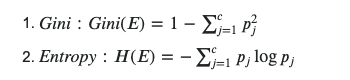

In [112]:
Image(filename = "ginivsent.png", width = 600, height = 300)

### RF + BoW

In [94]:
# Dividiendo el dataset para usar BoW
X_bow, X_test_bow, y_bow, y_test_bow = train_test_split(bow_emb_100, 
                                                        np.array(labels_), 
                                                        shuffle=False, 
                                                        test_size=0.2)

# Generando el set de train y validacion
X_train_bow, X_val_bow, y_train_bow, y_val_bow = train_test_split(X_bow, 
                                                                  y_bow, 
                                                                  shuffle=False, 
                                                                  test_size=0.2)

In [95]:
# Train set

warnings.filterwarnings("ignore")
criterions = ["entropy", "gini"]
n_trees = [2, 5, 10, 50, 100]
max_depths = [1, 10, 20, 50, 100]

for criterion_ in criterions:
    for trees in n_trees:
        for depth in max_depths:
            clf = RandomForestClassifier(n_estimators= trees, max_depth=depth, criterion= criterion_, random_state=0)
            clf.fit(X_train_bow, y_train_bow)
            y_pred = clf.predict(X_train_bow)
            print('Accuracy:', accuracy_score(y_train_bow, y_pred), '%', 'criterion_:',criterion_,', trees:', trees, 'depth:', depth)


Accuracy: 0.6805874573675785 % criterion_: entropy , trees: 2 depth: 1
Accuracy: 0.9584464397577782 % criterion_: entropy , trees: 2 depth: 10
Accuracy: 0.9981554952321292 % criterion_: entropy , trees: 2 depth: 20
Accuracy: 0.9980858912786246 % criterion_: entropy , trees: 2 depth: 50
Accuracy: 0.9980858912786246 % criterion_: entropy , trees: 2 depth: 100
Accuracy: 0.6805874573675785 % criterion_: entropy , trees: 5 depth: 1
Accuracy: 0.9584464397577782 % criterion_: entropy , trees: 5 depth: 10
Accuracy: 0.9981554952321292 % criterion_: entropy , trees: 5 depth: 20
Accuracy: 0.9980858912786246 % criterion_: entropy , trees: 5 depth: 50
Accuracy: 0.9980858912786246 % criterion_: entropy , trees: 5 depth: 100
Accuracy: 0.6805874573675785 % criterion_: entropy , trees: 10 depth: 1
Accuracy: 0.9584464397577782 % criterion_: entropy , trees: 10 depth: 10
Accuracy: 0.9981554952321292 % criterion_: entropy , trees: 10 depth: 20
Accuracy: 0.9980858912786246 % criterion_: entropy , trees: 10

In [98]:
# Validation set

warnings.filterwarnings("ignore")
criterions = ["entropy", "gini"]
n_trees = [2, 5, 10, 50, 100]
max_depths = [1, 10, 20, 50, 100]

for criterion_ in criterions:
    for trees in n_trees:
        for depth in max_depths:
            clf = RandomForestClassifier(n_estimators= trees, max_depth=depth, criterion= criterion_, random_state=0)
            clf.fit(X_train_bow, y_train_bow)
            y_pred = clf.predict(X_val_bow)
            print('Accuracy:', accuracy_score(y_val_bow, y_pred), '%', 'criterion_:',criterion_,', trees:', trees, 'depth:', depth)


Accuracy: 0.686108017817372 % criterion_: entropy , trees: 2 depth: 1
Accuracy: 0.9149498886414253 % criterion_: entropy , trees: 2 depth: 10
Accuracy: 0.9271993318485523 % criterion_: entropy , trees: 2 depth: 20
Accuracy: 0.928173719376392 % criterion_: entropy , trees: 2 depth: 50
Accuracy: 0.928173719376392 % criterion_: entropy , trees: 2 depth: 100
Accuracy: 0.686108017817372 % criterion_: entropy , trees: 5 depth: 1
Accuracy: 0.9149498886414253 % criterion_: entropy , trees: 5 depth: 10
Accuracy: 0.9271993318485523 % criterion_: entropy , trees: 5 depth: 20
Accuracy: 0.928173719376392 % criterion_: entropy , trees: 5 depth: 50
Accuracy: 0.928173719376392 % criterion_: entropy , trees: 5 depth: 100
Accuracy: 0.686108017817372 % criterion_: entropy , trees: 10 depth: 1
Accuracy: 0.9149498886414253 % criterion_: entropy , trees: 10 depth: 10
Accuracy: 0.9271993318485523 % criterion_: entropy , trees: 10 depth: 20
Accuracy: 0.928173719376392 % criterion_: entropy , trees: 10 depth: 

### RF + W2V

In [99]:
#SVM con Word2Vec con normalizacion por feature

X_w2v, X_test_w2v, y_w2v, y_test_w2v = train_test_split(X_w2v_per_feat, 
                                                        labels_, 
                                                        shuffle=False, 
                                                        test_size=0.2)

X_train_w2v, X_val_w2v, y_train_w2v, y_val_w2v = train_test_split(X_w2v, 
                                                                  y_w2v, 
                                                                  shuffle=False, 
                                                                  test_size=0.2)

In [100]:
# Train set

warnings.filterwarnings("ignore")

criterions = ["entropy", "gini"]
n_trees = [2, 5, 10, 50, 100]
max_depths = [1, 10, 20, 50, 100]

for criterion_ in criterions:
    for trees in n_trees:
        for depth in max_depths:
            clf = RandomForestClassifier(n_estimators= trees, max_depth=depth, criterion= criterion_, random_state=0)
            clf.fit(X_train_w2v, y_train_w2v)
            y_pred = clf.predict(X_train_w2v)
            print('Accuracy:', accuracy_score(y_train_w2v, y_pred), '%', 'criterion_:',criterion_,', trees:', trees, 'depth:', depth)


Accuracy: 0.857451103222663 % criterion_: entropy , trees: 2 depth: 1
Accuracy: 0.9741421312730563 % criterion_: entropy , trees: 2 depth: 10
Accuracy: 0.9980510893018724 % criterion_: entropy , trees: 2 depth: 20
Accuracy: 0.9979814853483678 % criterion_: entropy , trees: 2 depth: 50
Accuracy: 0.9979814853483678 % criterion_: entropy , trees: 2 depth: 100
Accuracy: 0.857451103222663 % criterion_: entropy , trees: 5 depth: 1
Accuracy: 0.9741421312730563 % criterion_: entropy , trees: 5 depth: 10
Accuracy: 0.9980510893018724 % criterion_: entropy , trees: 5 depth: 20
Accuracy: 0.9979814853483678 % criterion_: entropy , trees: 5 depth: 50
Accuracy: 0.9979814853483678 % criterion_: entropy , trees: 5 depth: 100
Accuracy: 0.857451103222663 % criterion_: entropy , trees: 10 depth: 1
Accuracy: 0.9741421312730563 % criterion_: entropy , trees: 10 depth: 10
Accuracy: 0.9980510893018724 % criterion_: entropy , trees: 10 depth: 20
Accuracy: 0.9979814853483678 % criterion_: entropy , trees: 10 de

In [77]:
# Validation set
warnings.filterwarnings("ignore")

criterions = ["entropy", "gini"]
n_trees = [2, 20, 50, 100, 1000, 10000]
max_depths = [1, 10, 20, 50, 100]

for criterion_ in criterions:
    for trees in n_trees:
        for depth in max_depths:
            clf = RandomForestClassifier(n_estimators= trees, max_depth=depth, criterion= criterion_, random_state=0)
            clf.fit(X_train_w2v, y_train_w2v)
            y_pred = clf.predict(X_val_w2v)
            print('Accuracy:', accuracy_score(y_val_w2v, y_pred), '%', 'criterion_:',criterion_,', trees:', trees, 'depth:', depth)


Accuracy: 0.8574610244988864 % criterion_: entropy , trees: 2 depth: 1
Accuracy: 0.9452951002227171 % criterion_: entropy , trees: 2 depth: 10
Accuracy: 0.9582405345211581 % criterion_: entropy , trees: 2 depth: 20
Accuracy: 0.9562917594654788 % criterion_: entropy , trees: 2 depth: 50
Accuracy: 0.9562917594654788 % criterion_: entropy , trees: 2 depth: 100
Accuracy: 0.8574610244988864 % criterion_: entropy , trees: 20 depth: 1
Accuracy: 0.9452951002227171 % criterion_: entropy , trees: 20 depth: 10
Accuracy: 0.9582405345211581 % criterion_: entropy , trees: 20 depth: 20
Accuracy: 0.9562917594654788 % criterion_: entropy , trees: 20 depth: 50
Accuracy: 0.9562917594654788 % criterion_: entropy , trees: 20 depth: 100
Accuracy: 0.8574610244988864 % criterion_: entropy , trees: 50 depth: 1
Accuracy: 0.9452951002227171 % criterion_: entropy , trees: 50 depth: 10
Accuracy: 0.9582405345211581 % criterion_: entropy , trees: 50 depth: 20
Accuracy: 0.9562917594654788 % criterion_: entropy , tree

### RF + BERT

In [78]:
#SVM con Word2Vec con normalizacion por observacion o texto

X_bert_obs, X_test_bert, y_bert_obs, y_test_bert = train_test_split(ft_bert, 
                                                                    labels_bert, 
                                                                    shuffle=False, 
                                                                    test_size=0.2)

X_train_bert, X_val_bert, y_train_bert, y_val_bert = train_test_split(X_bert_obs, 
                                                                  y_bert_obs, 
                                                                  shuffle=False, 
                                                                  test_size=0.2)

In [90]:
# Train set

warnings.filterwarnings("ignore")
criterions = ["entropy", "gini"]
n_trees = [2, 5, 10, 50, 100]
max_depths = [1, 10, 20, 40, 100]

for criterion_ in criterions:
    for trees in n_trees:
        for depth in max_depths:
            clf = RandomForestClassifier(n_estimators= trees, max_depth=depth, criterion= criterion_, random_state=0)
            clf.fit(X_train_bert, y_train_bert)
            y_pred_val_bert = clf.predict(X_train_bert)
            print('Accuracy:', accuracy_score(y_pred_val_bert, y_train_bert), '%', 'criterion_:',criterion_,', trees:', trees, 'depth:', depth)

Accuracy: 0.7512419900640794 % criterion_: entropy , trees: 2 depth: 1
Accuracy: 0.9573403412772697 % criterion_: entropy , trees: 2 depth: 10
Accuracy: 0.967312261501908 % criterion_: entropy , trees: 2 depth: 20
Accuracy: 0.967312261501908 % criterion_: entropy , trees: 2 depth: 40
Accuracy: 0.967312261501908 % criterion_: entropy , trees: 2 depth: 100
Accuracy: 0.789797681618547 % criterion_: entropy , trees: 5 depth: 1
Accuracy: 0.9817121463028295 % criterion_: entropy , trees: 5 depth: 10
Accuracy: 0.9955720354237166 % criterion_: entropy , trees: 5 depth: 20
Accuracy: 0.9955720354237166 % criterion_: entropy , trees: 5 depth: 40
Accuracy: 0.9955720354237166 % criterion_: entropy , trees: 5 depth: 100
Accuracy: 0.7922456620347037 % criterion_: entropy , trees: 10 depth: 1
Accuracy: 0.9874361005111959 % criterion_: entropy , trees: 10 depth: 10
Accuracy: 0.9982000143998848 % criterion_: entropy , trees: 10 depth: 20
Accuracy: 0.9982000143998848 % criterion_: entropy , trees: 10 dep

In [83]:
# Validation set

warnings.filterwarnings("ignore")
criterions = ["entropy", "gini"]
n_trees = [2, 5, 10, 50, 100]
max_depths = [1, 10, 20, 40, 100]

for criterion_ in criterions:
    for trees in n_trees:
        for depth in max_depths:
            clf = RandomForestClassifier(n_estimators= trees, max_depth=depth, criterion= criterion_, random_state=0)
            clf.fit(X_train_bert, y_train_bert)
            y_pred_val_bert = clf.predict(X_val_bert)
            print('Accuracy:', accuracy_score(y_pred_val_bert, y_val_bert), '%', 'criterion_:',criterion_,', trees:', trees, 'depth:', depth)

Accuracy: 0.7652987760979122 % criterion_: entropy , trees: 2 depth: 1
Accuracy: 0.9095752339812815 % criterion_: entropy , trees: 2 depth: 10
Accuracy: 0.9052555795536357 % criterion_: entropy , trees: 2 depth: 20
Accuracy: 0.9052555795536357 % criterion_: entropy , trees: 2 depth: 40
Accuracy: 0.9052555795536357 % criterion_: entropy , trees: 2 depth: 100
Accuracy: 0.7982721382289417 % criterion_: entropy , trees: 5 depth: 1
Accuracy: 0.9527717782577394 % criterion_: entropy , trees: 5 depth: 10
Accuracy: 0.9513318934485241 % criterion_: entropy , trees: 5 depth: 20
Accuracy: 0.9513318934485241 % criterion_: entropy , trees: 5 depth: 40
Accuracy: 0.9513318934485241 % criterion_: entropy , trees: 5 depth: 100
Accuracy: 0.8025917926565874 % criterion_: entropy , trees: 10 depth: 1
Accuracy: 0.9612670986321095 % criterion_: entropy , trees: 10 depth: 10
Accuracy: 0.9601151907847372 % criterion_: entropy , trees: 10 depth: 20
Accuracy: 0.9601151907847372 % criterion_: entropy , trees: 10

**Presentación de resultados en tablas**. Como hice muchos experimentos, he truncado los valores que eran iguales. Es decir, si el numero de "Depth" no incidia en más de un 0.1% de ganancia de accuracy, dejamos de reportar para los depths siguientes. Usualmente esto era observado, en donde aumentar el numero de profundidad no ayudaba. Esto es probablemente ya que el arbol llega a su maxima altura con los datos presentados y no caambia en nada seguir dandole permiso para crecer.



## BoW

- Training set. 

n_estimator | max_depth | entropia | gini
--- | --- | --- | ---
2 | 1  | 68.05 | 68.04 
2 | 10 | 95.84 | 96.04
2 | 20 | 99.81 | 99.79
5 | 1  | 68.05 | 68.04
5 | 10 | 95.84 | 96.04
5 | 20 | 99.81 | 99.79
10 | 1  | 68.05 | 68.04
10 | 10 | 95.84 | 96.04
10 | 20 | 99.81 | 99.79
50 | 1  | 6805 | 68.04
50 | 10 | 9584 | 96.04
50 | 20 | 99.81 | 99.79
100 | 1  | 68.05 | 68.04
100 | 10 | 95.84 | 96.04
100 | 20 | 99.81 | 99.79

- Validation set

n_estimator | max_depth | entropia | gini
--- | --- | --- | ---
2 | 1  | 68.61 | 68.51 
2 | 10 | 91.49 | 91.75
2 | 20 | 92.71 | 92.73
5 | 1  | 68.61 | 68.51
5 | 10 | 91.49 | 91.75
5 | 20 | 92.71 | 92.73
10 | 1  | 68.61 | 68.51
10 | 10 | 91.49 | 91.75
10 | 20 | 92.71 | 92.73
50 | 1  | 68.61 | 68.51
50 | 10 | 91.49 | 91.75
50 | 20 | 92.71 | 92.73
100 | 1  | 68.61 | 68.51
100 | 10 | 91.49 | 91.75
100 | 20 | 92.71 | 92.73



## W2V + Normalización por observación

- Se omite la tabla ya que los maximos se vieron en normalización por feature. Los resultados se dejan expresados más arriba. 

## W2V + Normalización por feature

- Training set. 

n_estimator | max_depth | entropia | gini
--- | --- | --- | ---
2 | 1  | 85.74 | 85.64 
2 | 10 | 97.41 | 96.97
2 | 20 | 99.80 | 99.80
5 | 1  | 85.74 | 85.64
5 | 10 | 97.41 | 99.80
10 | 1  | 85.74 | 85.64
10 | 10 | 97.41 | 96.97
50 | 1  | 85.74 | 85.64
50 | 10 | 97.41 | 96.97
50 | 10 | 99.80 | 99.80
100 | 1  | 85.74 | 85.64
100 | 10 | 97.41 | 96.97
100 | 20 | 99.80 | 99.80


- Validation set

n_estimator | max_depth | entropia | gini
--- | --- | --- | ---
2 | 1  | 85.74 | 94.52 
2 | 10 | 94.52 | 94.58
2 | 20 | 95.82 | 95.46
5 | 1  | 85.74 |85.70
5 | 10 | 94.52 | 94.58
100 | 1  | 85.74 | 85.74
100 | 10 | 94.52 | 94.58



## BERT

- Training set. 

n_estimator | max_depth | entropia | gini
--- | --- | --- | ---
2 | 1  | 75.12 | 75.12 
2 | 10 | 95.73 | 95.29
2 | 20 | 96.73 | 95.29
5 | 1  | 78.97 | 79.00
5 | 10 | 98.17 | 97.67
5 | 20 | 99.55 | 99.44
10 | 1  | 79.22 | 78.85
10 | 10 | 98.74 | 98.28
50 | 1  | 87.27 | 87.24
50 | 10 | 99.11 | 98.70
100 | 1  | 87.28 | 87.28
100 | 10 | 99.11 | 98.68
100 | 20 | 100 | 99.95




- Validation set

n_estimator | max_depth | entropia | gini
--- | --- | --- | ---
2 | 1  | 76.52 | 76.52
2 | 10 | 90.95 | 90.46
5 | 1  | 78.97 | 89.83
5 | 10 | 98.17 | 79.95
10 | 1  | 80.25 | 79.91
10 | 10 | 96.12 | 95.66
50 | 1  | 87.40 | 87.27
50 | 10 | 96.76 | 96.18
100 | 10 | 87.58 | 87.57
100 | 20 | 96.70 | 96.34


- **¿Mejor rendimiento en los conjuntos de train?** 

Los mejores resultados fueron presentados por BERT y BoW.

- **¿Mejor rendimiento en los conjuntos de validación?** 

Aquí BERT se impuso fuertemente frente a los otros.

Algo interesante en Random Forests es que los clasificadores llegan a un máximo al variar la cantidad de profundidad maxima. Por intuición esto podría significar que el árbol ya llego a su profundidad maxima y, por mas que le dejemos crecer mas, ya completó todos sus niveles.

El numero de arboles también tiene una gran incidencia en los resultados que vemos. Esto podría estar generando overfitting en algunos casos. Es imperativo generar una buena combinación de profundidad / cantidad de árboles.


## AC06: Mejor Random Forest

Como podemos ver en las tablas, **RF + Bert** presentó los mejores resultados, comparando según rendimientos de set de validacion. Es por esto que elegiremos esta combinación, con los hiperparametros que resultaron más eficientes, para probar nuestro set de test.

In [138]:
clf = RandomForestClassifier(n_estimators= 5, max_depth=10, criterion= "entropy")
clf.fit(X_train_bert, y_train_bert)
y_pred_test_bert = clf.predict(X_test_bert)
print(accuracy_score(y_test_bert, y_pred_test_bert))

0.9525400299504665


In [140]:
for noticia_idx in range(300, 315):
    print("La noticia: ")
    print(test_df['title'].iloc[noticia_idx])
    print("Tenia un valor real de")
    print(labels_bert[noticia_idx])
    print("Y fue predicha como")
    print(y_pred_test_bert[noticia_idx])
    print("\n")


La noticia: 
 WATCH: Democratic Rep SHREDS Republicans For Trying To Repeal Obamacare
Tenia un valor real de
0
Y fue predicha como
0


La noticia: 
 ‘Racist, Fascist, White Supremacist’: Former NFL Star Chris Kluwe Scorches Trump Over His Attacks On Atheletes
Tenia un valor real de
0
Y fue predicha como
0


La noticia: 
Trump revokes Obama guidelines on transgender bathrooms
Tenia un valor real de
0
Y fue predicha como
0


La noticia: 
BREAKING: VIOLENCE ERUPTS Outside Of “Deploraball,” Streets Of D.C. Against Trump Supporters [VIDEO]
Tenia un valor real de
0
Y fue predicha como
1


La noticia: 
Secret U.S. court issues first order for phone data under new law
Tenia un valor real de
0
Y fue predicha como
0


La noticia: 
 WATCH: Even Investigation-Obsessed GOP Rep. Jason Chaffetz Says Trump Has No Proof Obama Wiretapped Him
Tenia un valor real de
1
Y fue predicha como
0


La noticia: 
Factbox: First 100 days of Trump on Twitter
Tenia un valor real de
1
Y fue predicha como
1


La notici

## AC07: Mejor clasificador entre todos

Luego de crear multiples experimentos y **muchas** horas de procesamiento, podemos determinar que el método ganador fue  vemos que el mejor clasificador ha sido **BERT + SVM** con un **98.97%**.


Podemos observar que la incidencia de los hiperparametros en realmente importante, presentando gran variabilidad de resultados en las tablas de resumen presentadas en cada AC.   

Podemos observar como, al usar Word2Vec, existe una incidencia también en si normalizamos o no, si agrupamos por feature o observación, y que tanto en SVM como en RF, existe alta sensibilidad a cambios en la forma en que construimos los hiperplanos.

En BERT, si bien solemos observar los mejores resultados, también apreciamos la incidencia de estos hiperparametros, como es el caso del C en SVM o n_estimators en RF.


Como ya mencionamos, en SVM, vemos como el factor C es muy importante en los resultados que tenemos. En el kernel lineal vemos que la accuracy suele crecer en conjunto a C, pero también notamos algo interesante: existe un tope. Una vez que el C sigue creciendo, el accuracy baja. Esto se podría deber a que estamos viendo un overfit.

El kernel polinomial presenta los peores rendimientos en general, a pesar de variar su C. La razón de esto es, probablemente, debida a la naturaleza y mezcla de datos.

RDF suele crecer junto a C, presentando grandes saltos una vez que llegamos a un C óptimo. Esto nos hace pensar que RDF es mas sensible al valor de la penalización de clases que los otros tipos.

Algo interesante en Random Forests es que los clasificadores llegan a un máximo al variar la cantidad de profundidad maxima. Por intuición esto podría significar que el árbol ya llego a su profundidad maxima y, por mas que le dejemos crecer mas, ya completó todos sus niveles.

El numero de arboles también tiene una gran incidencia en los resultados que vemos. Esto podría estar generando overfitting en algunos casos. Es imperativo generar una buena combinación de profundidad / cantidad de árboles.

En la comparación de ambos, Random Forests es mucho más rápido que SVM. Esto se debe probablemente a que la generación de los hiperplanos, en especial en el caso de polinomio, demora much debido a la gran mezcla de datos que tenemos.